In [2]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [3]:

# train data
image_folder_train = '2018/images/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input'
image_files_train = os.listdir(image_folder_train)
# Load images and store them in a list
images_train = [cv2.imread(os.path.join(image_folder_train, file_name)) for file_name in image_files_train]




In [4]:
# test data
image_folder_test = '2018/images/ISIC2018_Task3_Test_Images'
image_files_test = os.listdir(image_folder_test)
# Load images and store them in a list
images_test = [cv2.imread(os.path.join(image_folder_test, file_name)) for file_name in image_files_test]

In [5]:
# validation data
image_folder_valid = '2018/images/ISIC2018_Task3_Validation_Input'
image_files_valid = os.listdir(image_folder_valid)
# Load images and store them in a list
images_valid = [cv2.imread(os.path.join(image_folder_valid, file_name)) for file_name in image_files_valid]

In [6]:
# train data
# Load csv file containing image filenames and corresponding labels
csv_file_path_train = '2018/CSV_mapped/ISIC2018_Task3_Training_GroundTruth.csv'
csv_data_train = pd.read_csv(csv_file_path_train)
# Extract image filenames and corresponding labels
image_filenames_train = csv_data_train['image']
labels_train = csv_data_train['Disease_Label']

In [7]:
# validation data
# Load csv file containing image filenames and corresponding labels
csv_file_path_valid = '2018/CSV_mapped/ISIC2018_Task3_Validation_GroundTruth.csv'
csv_data_valid = pd.read_csv(csv_file_path_valid)
# Extract image filenames and corresponding labels
image_filenames_valid = csv_data_valid['image']
labels_valid = csv_data_valid['Disease_Label']

In [8]:
# test data
# Load csv file containing image filenames and corresponding labels
csv_file_path_test = '2018/CSV_mapped/ISIC2018_Task3_Test_GroundTruth.csv'
csv_data_test = pd.read_csv(csv_file_path_test)
# Extract image filenames and corresponding labels
image_filenames_test = csv_data_test['image']

labels_test = csv_data_test['Disease_Label']

In [9]:
# iterate over csv
for image_name in image_filenames_test:
    # image_file_test=image from csv
    image_name = str(image_name) + '.jpg'

    if image_name not in image_files_test:
        print(image_name)


In [10]:
for file_name, image in zip(image_files_train, images_test):
    if image is None or image.size == 0:
        print(f"Failed to load image: {file_name}")

In [11]:
for file_name, image in zip(image_files_train, images_valid):
    if image is None or image.size == 0:
        print(f"Failed to load image: {file_name}")

In [12]:
for file_name, image in zip(image_files_train, images_train):
    if image is None or image.size == 0:
        print(f"Failed to load image: {file_name}")


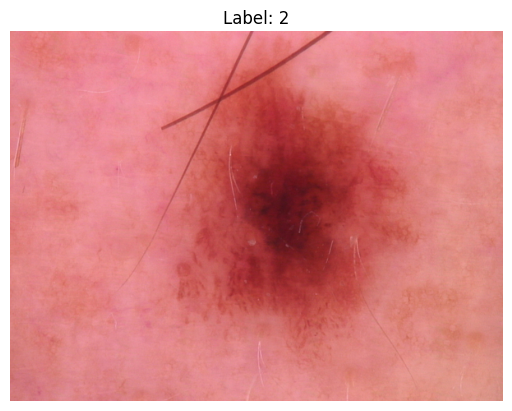

In [14]:


# Choose an index to display
index_to_display = 0

# Display the image
plt.imshow(cv2.cvtColor(images_train[index_to_display], cv2.COLOR_BGR2RGB))
plt.title(f"Label: {labels_train[index_to_display]}")
plt.axis('off')  # Turn off axis labels
plt.show()


# preprocessing  #

In [15]:
#  Resize images to a common size (e.g., 32x32)
images_train = [cv2.resize(image, (32, 32)) for image in images_train]
images_test = [cv2.resize(image, (32, 32)) for image in images_test]
images_valid = [cv2.resize(image, (32, 32)) for image in images_valid]



In [16]:
images_train, images_test , images_valid = np.array(images_train), np.array(images_test ),np.array( images_valid)

In [17]:
images_train.shape

(10015, 32, 32, 3)

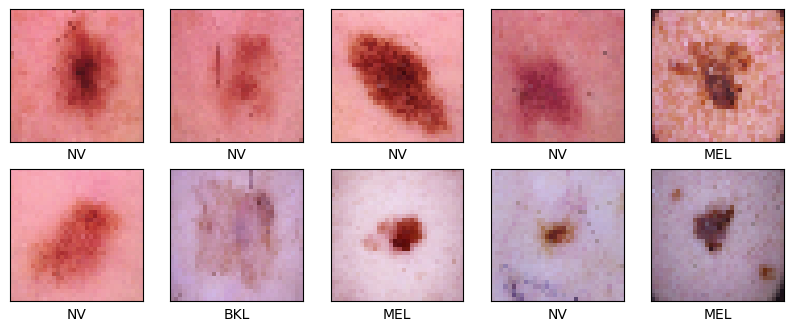

In [18]:

class_names = ['None', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
plt.figure(figsize=(10, 10))

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)

    # Normalize and convert image to uint8
    plt.imshow(cv2.cvtColor(images_train[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(class_names[labels_train[i]])

plt.show()





# ResNet  model

In [36]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [37]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [38]:
from tensorflow.keras.utils import to_categorical


In [39]:

labels_train_one_hot = to_categorical(labels_train, num_classes=8)
labels_valid_one_hot = to_categorical(labels_valid, num_classes=8)


In [42]:
model = tl_model.fit(images_train, labels_train_one_hot, epochs=15, validation_data=(images_valid, labels_valid_one_hot))


Epoch 1/15
313/313 [==============================] - 518s 2s/step - loss: 0.6332 - accuracy: 0.9095 - val_loss: 1.0203 - val_accuracy: 0.7824
Epoch 2/15
313/313 [==============================] - 448s 1s/step - loss: 0.5258 - accuracy: 0.9248 - val_loss: 0.8474 - val_accuracy: 0.7979
Epoch 3/15
313/313 [==============================] - 485s 2s/step - loss: 0.4253 - accuracy: 0.9363 - val_loss: 0.7240 - val_accuracy: 0.8497
Epoch 4/15
313/313 [==============================] - 495s 2s/step - loss: 0.3438 - accuracy: 0.9500 - val_loss: 0.8574 - val_accuracy: 0.7979
Epoch 5/15
313/313 [==============================] - 544s 2s/step - loss: 0.3027 - accuracy: 0.9527 - val_loss: 0.7500 - val_accuracy: 0.8238
Epoch 6/15
313/313 [==============================] - 504s 2s/step - loss: 0.2638 - accuracy: 0.9543 - val_loss: 0.8672 - val_accuracy: 0.7927
Epoch 7/15
313/313 [==============================] - 429s 1s/step - loss: 0.2345 - accuracy: 0.9559 - val_loss: 0.8244 - val_accuracy: 0.7720